# #11 : Survival Analysis

In [4]:
library(tidyverse)
library(readxl)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --

√ tibble  3.0.1     √ purrr   0.3.4
√ tidyr   1.1.0     √ dplyr   1.0.0
√ readr   1.3.1     √ stringr 1.4.0
√ tibble  3.0.1     √ forcats 0.4.0

Warning message:
"package 'tibble' was built under R version 3.6.3"
Warning message:
"package 'tidyr' was built under R version 3.6.3"
Warning message:
"package 'purrr' was built under R version 3.6.3"
Warning message:
"package 'dplyr' was built under R version 3.6.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter()  masks stats::filter()
x purrr::flatten() masks jsonlite::flatten()
x dplyr::lag()     masks stats::lag()



## PART 1. Failure Times of Springs 
**stress 수준** x의 변화에 따른 **스프링의 생존시간($t_i$)의 분포의 변화**를 나타내는 적절한 **회귀모형**을 찾는다. 
* $y_{ij} = min(t_{ij}, c_{ij})$ 
  - $t_{ij}$ : failure times (10^3 cycles) of springs
  - $c_{ij}$ : censoring times (10^3 cycles) of springs 
* $\delta_{ij} = I(t_{ij} \leq c_{ij}) =$  1 (uncensored) / 0 (censored) 
* $x_i$ : stress (N/${mm}^2$), (700, 750, ... , 950 - 6 levels) 
* \+ : right censored data ; $\delta_{ij} = 0 $ 
* $i = 1, ..., m ; j = 1, ..., n ; m = 6, n = 10$

In [5]:
spring <- read_excel("Spring-Failure-Stanford-heart-Transplant.xls",
                     sheet = "Spring-Failure-Data")
spring <- gather(spring, 'x','y', 1:6)
index <- grep('[+]', spring$y) 
spring[,3] <- 1; spring[index,3] <- 0 # if [+] 0, else 1
colnames(spring) <- c('x','y','delta') 
spring$y <- gsub('[+]', '',spring$y)
spring$x <- gsub('S','', spring$x)
spring <- mutate(spring, x = as.numeric(x), y= as.numeric(y), delta = as.numeric(delta))

### (a) (lny, x), (lny, lnx) 산점도 

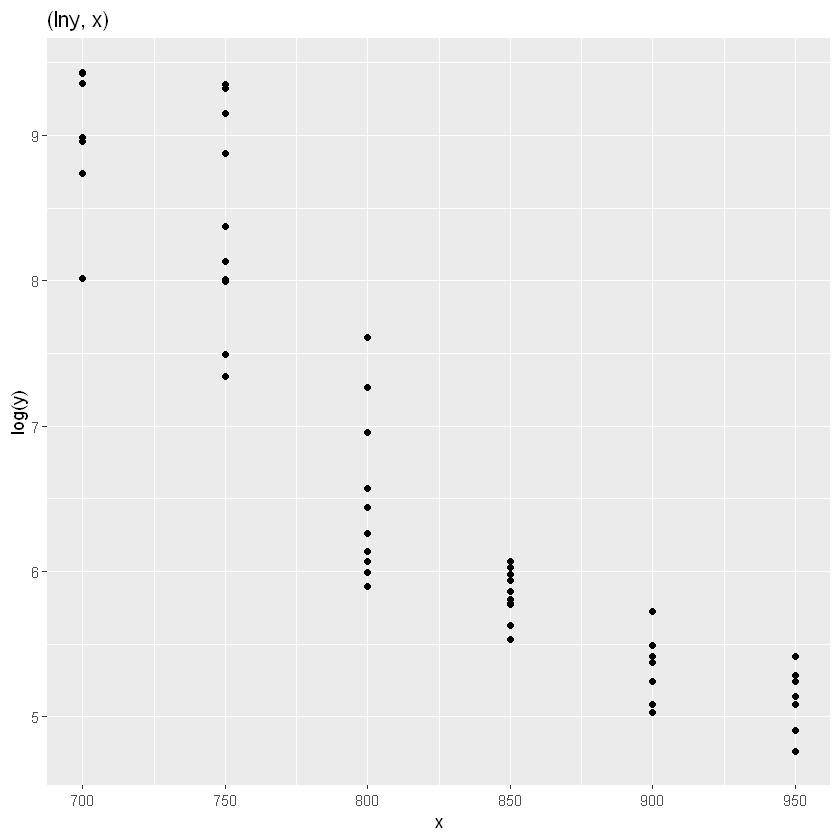

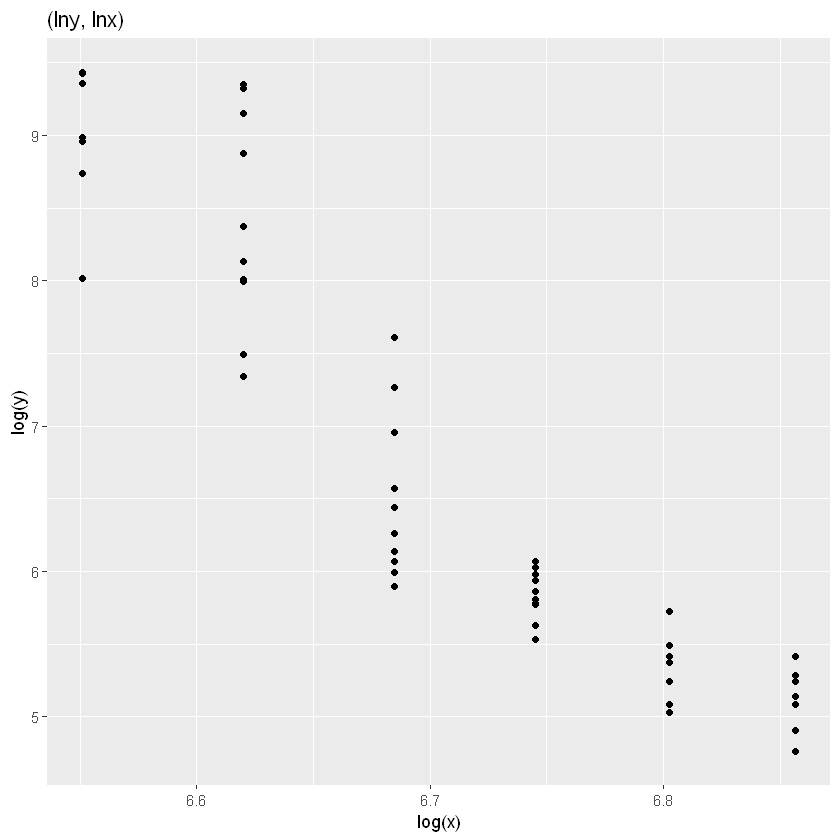

In [3]:
ggplot(data = spring) + geom_point(aes(x=x, y = log(y))) + ggtitle('(lny, x)')
ggplot(data = spring) + geom_point(aes(x=log(x), y = log(y))) + ggtitle('(lny, lnx)')

* stress 수준이 증가할수록 수명(failure time)이 짧아진다. 

### (b) uncensored data의 분포 및 모수 추정 
* $x_i = 800,850,900,950$인 경우

#### uncensored (complete) vs censored 
* x = 800,850,900,950 : 스트레스가 많으면 스프링의 수명이 단축되어, 모든 자료가 완전자료가 된다.        
  (모수 추정 용이함) 
* x = 700,750 : 스트레스가 적으면 스프링의 수명이 길어져서, 일부 자료가 절단되어 불완전 자료가 된다.      
  (모수 추정의 정확도 감소)

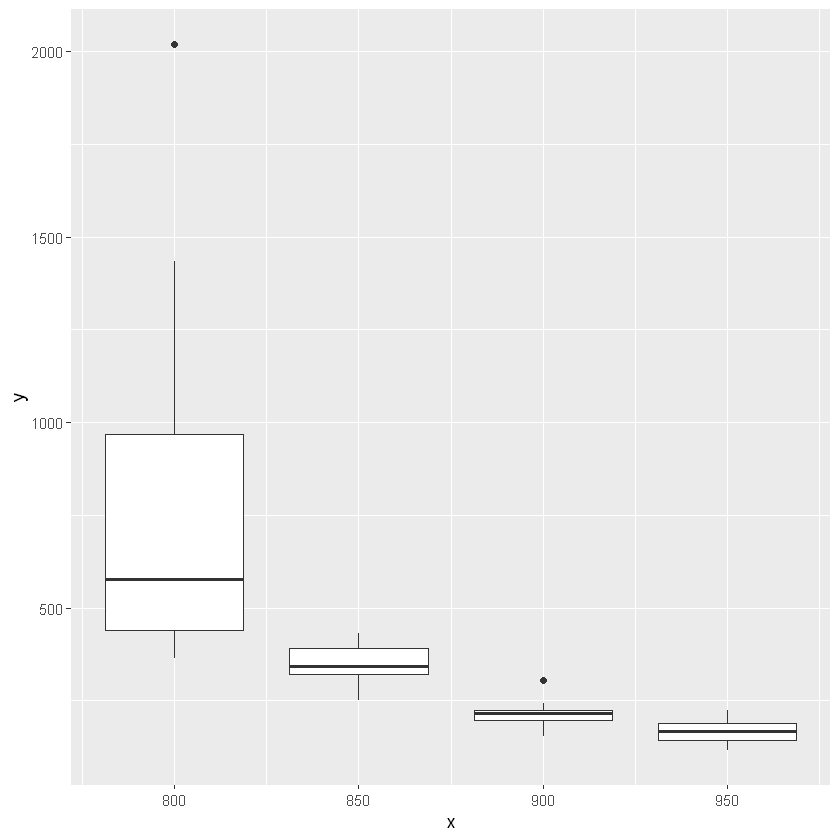

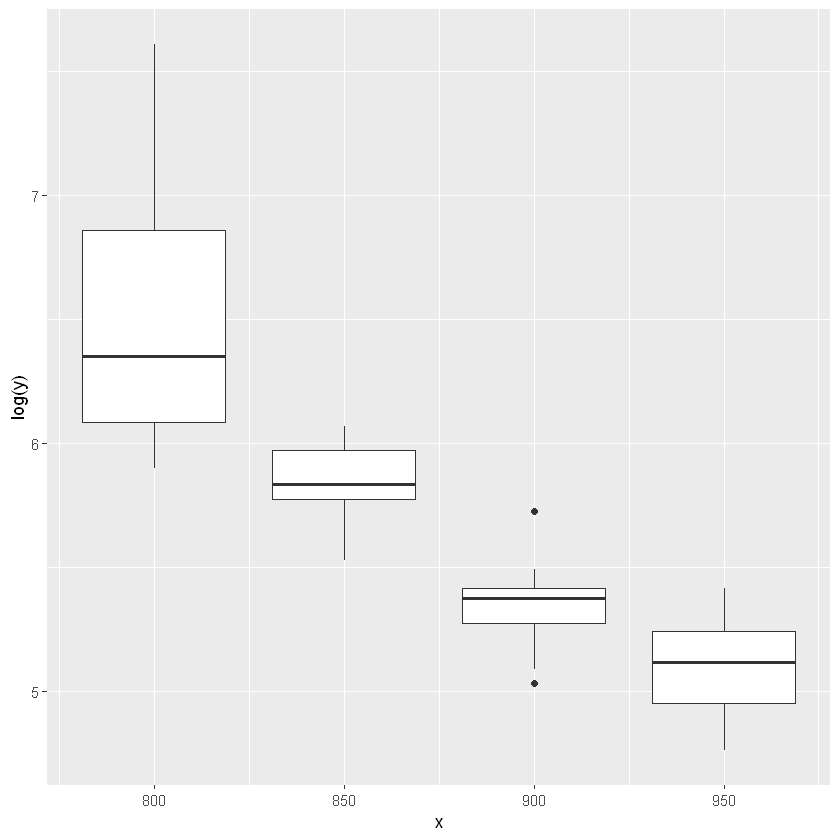

In [4]:
spring_ucs <- filter(spring, x >= 800) %>% filter(delta==1)
ggplot(data = spring_ucs, aes(x = x, y = y)) + geom_boxplot(aes(group = x))
ggplot(data = spring_ucs, aes(x = x, y = log(y))) + geom_boxplot(aes(group = x))

* stress 수준이 증가할수록 수명(failure time)이 짧아진다. 

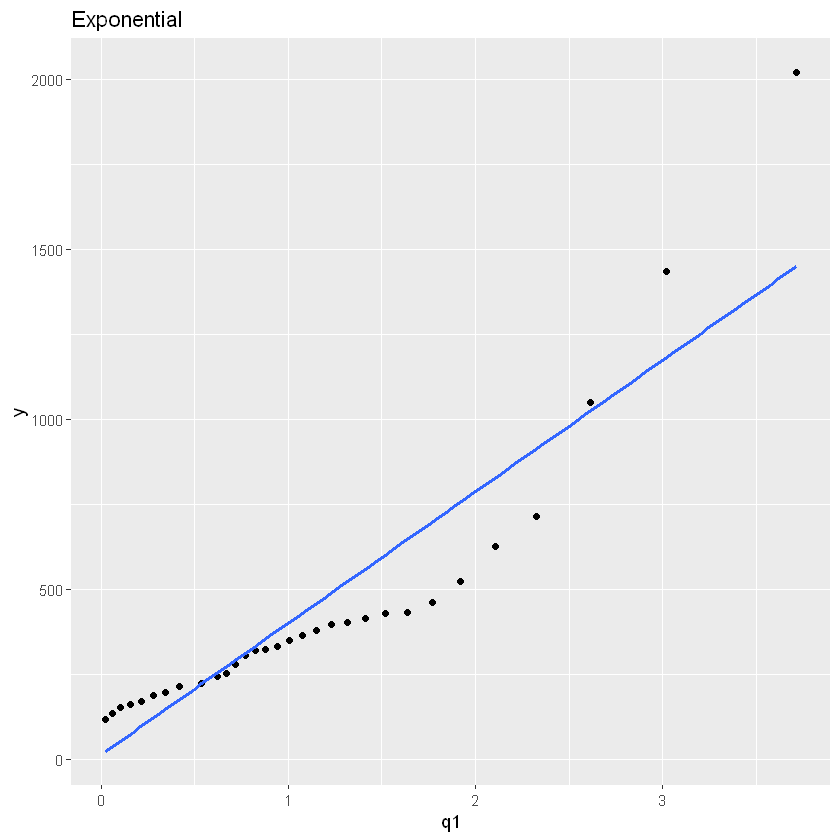

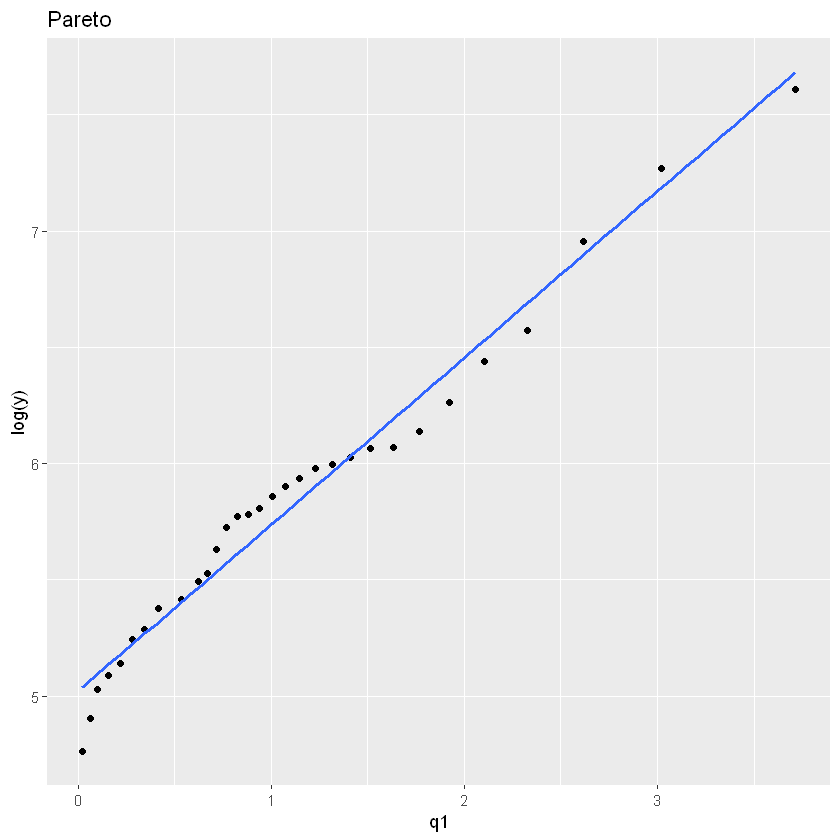

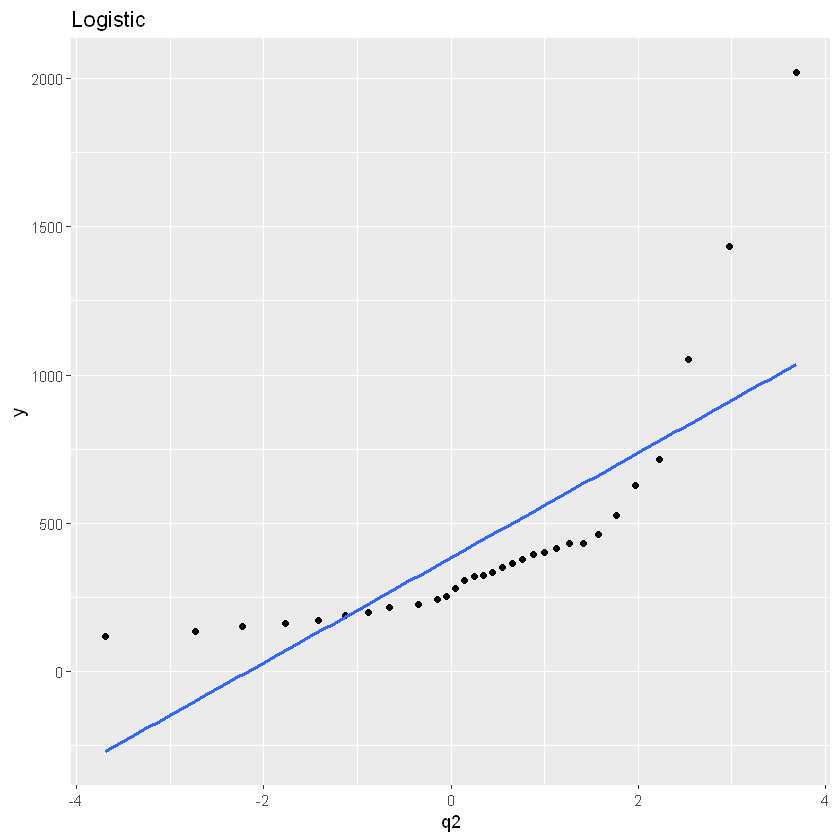

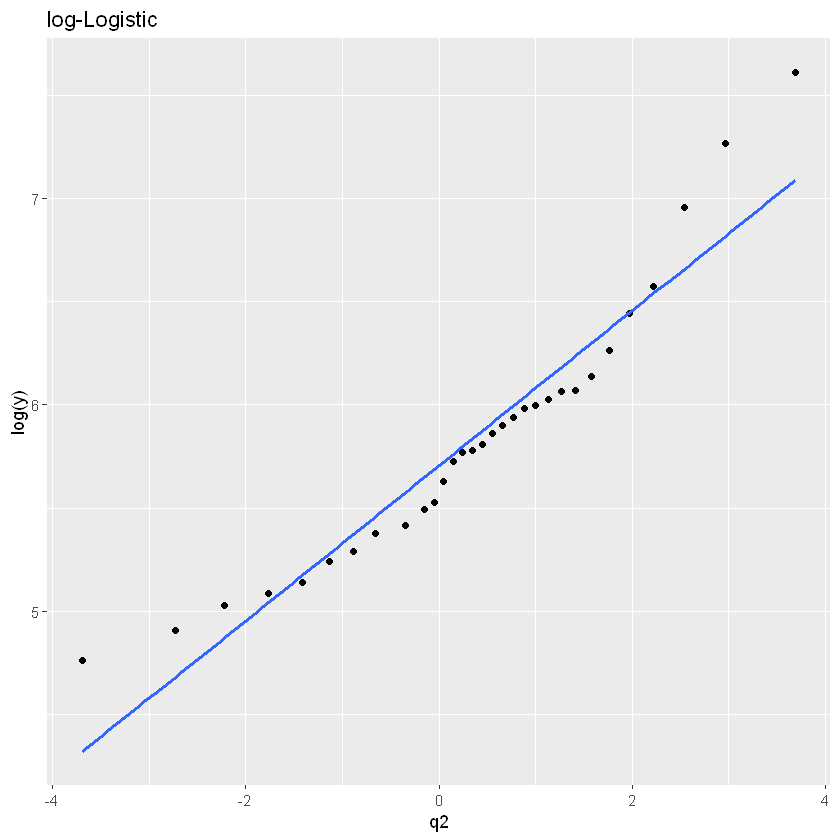

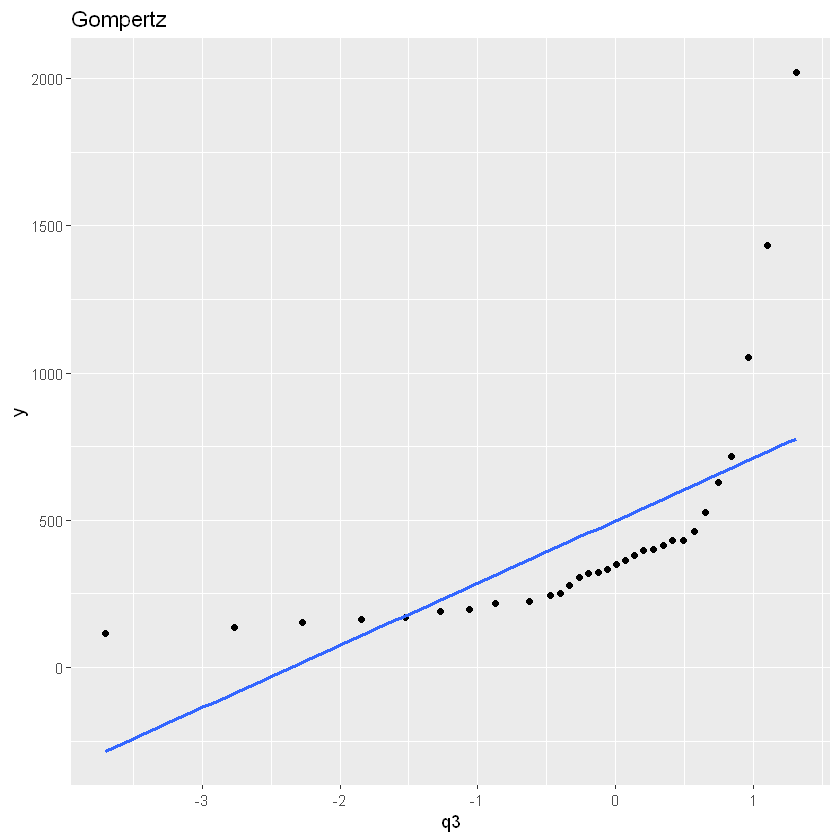

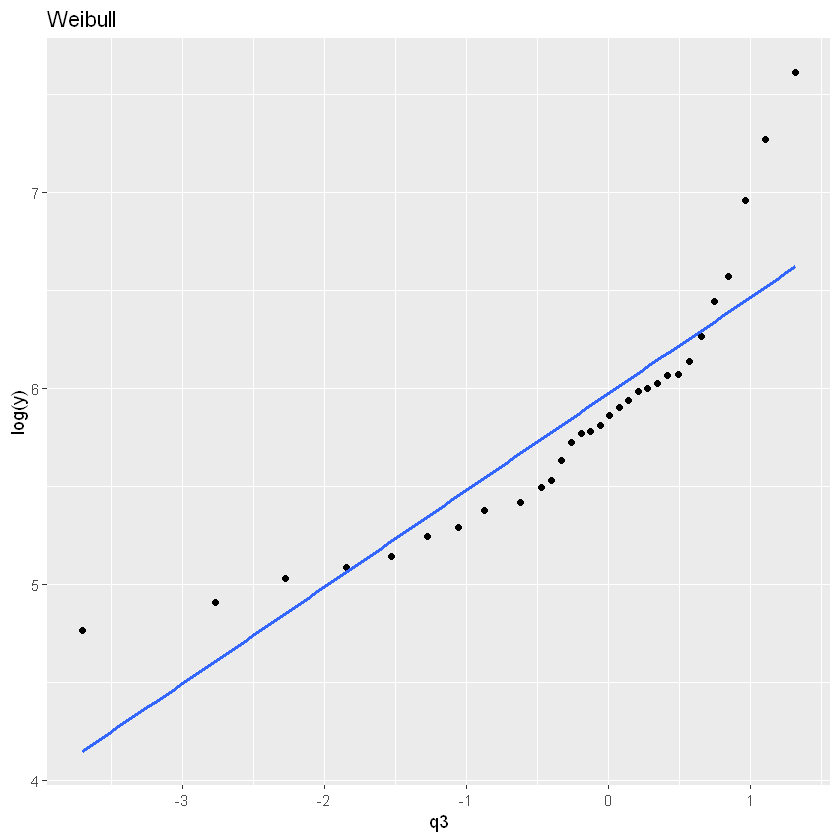

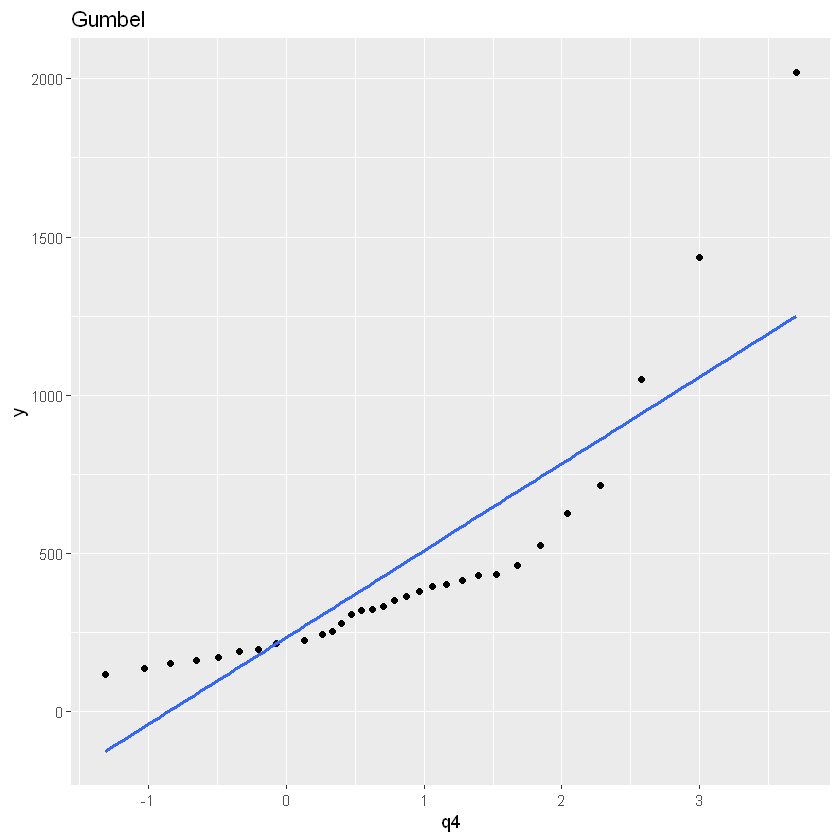

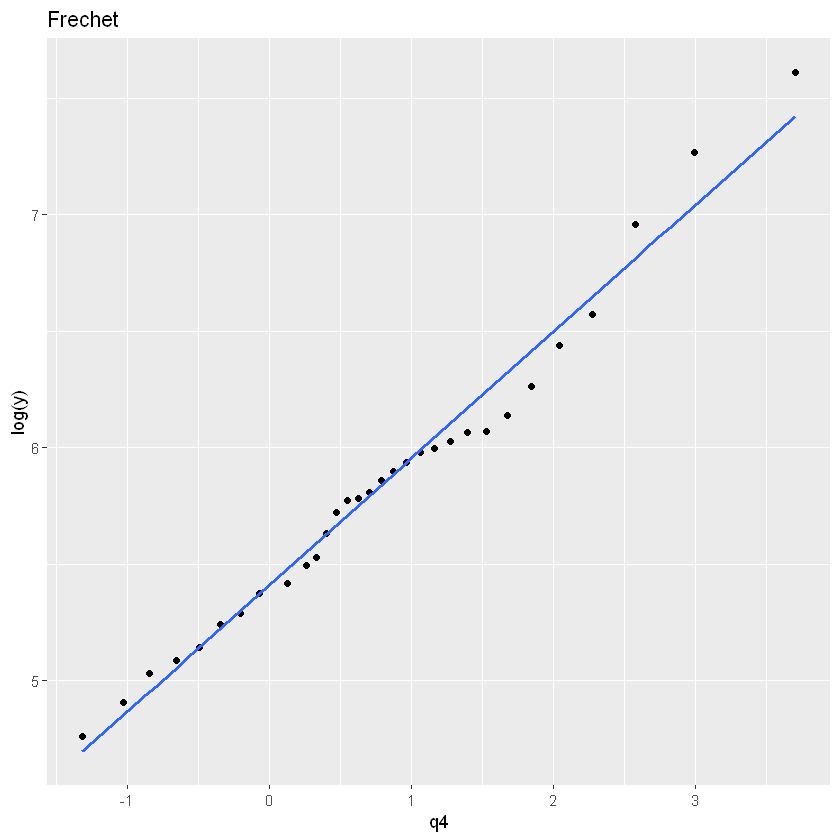

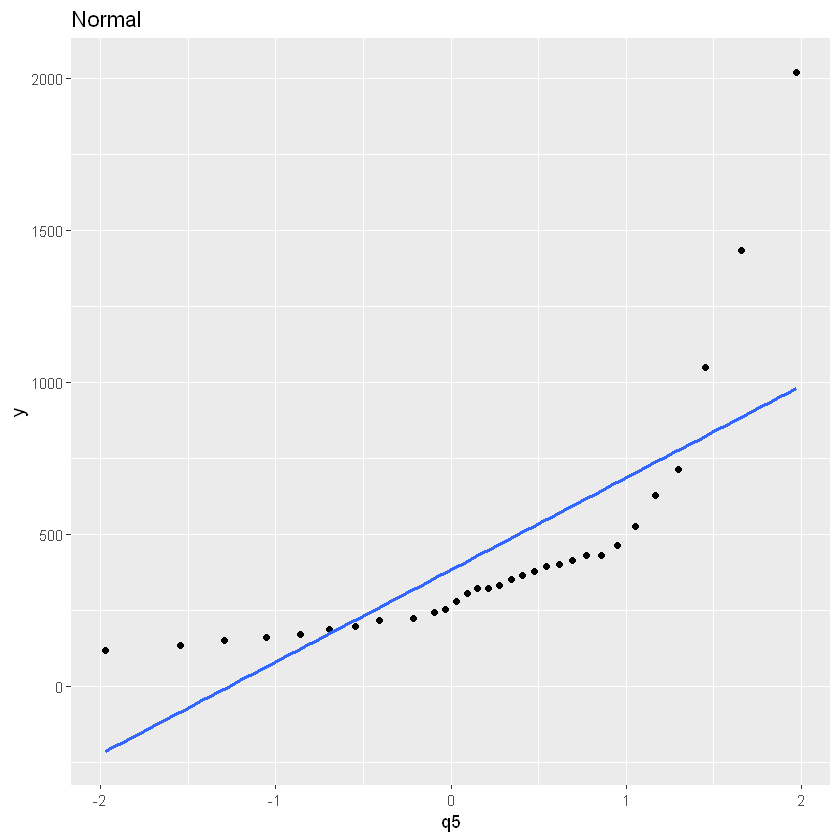

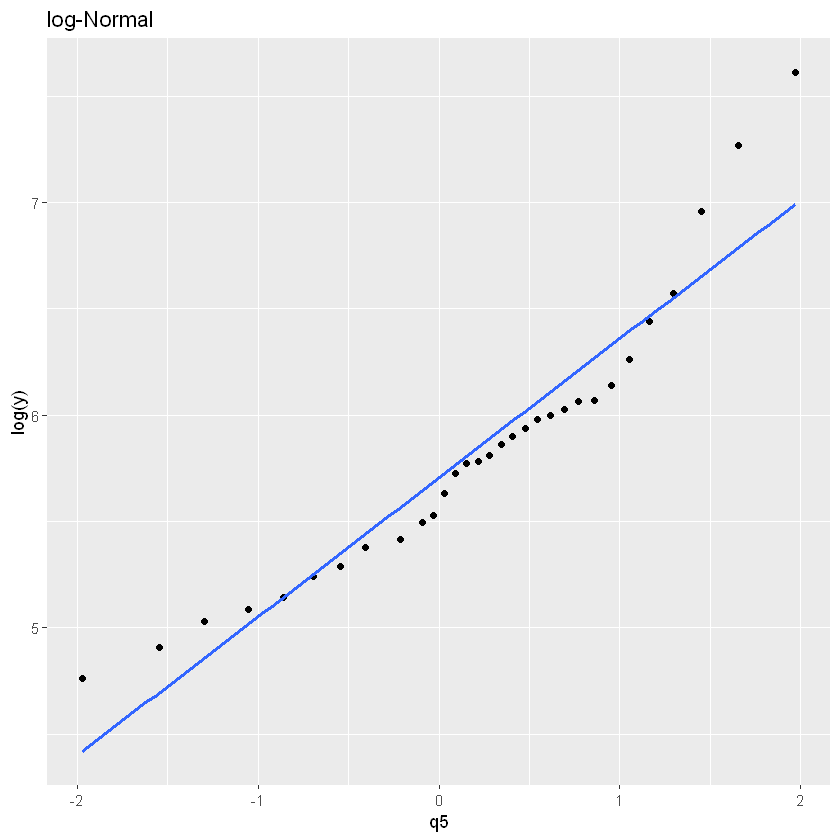

In [5]:
# Distributions
spring_ucs <- spring_ucs %>% mutate(r=rank(y),p=r/(nrow(spring_ucs)+1),q1=-log(1-p),q2=log(p/(1-p)),q3=log(-log(1-p)),q4=-log(-log(p)),q5=qnorm(p))
ggplot(spring_ucs,aes(q1,y))+geom_point()+geom_smooth(method="lm",se=F)+ggtitle("Exponential")
ggplot(spring_ucs,aes(q1,log(y)))+geom_point()+geom_smooth(method="lm",se=F)+ggtitle("Pareto")
ggplot(spring_ucs,aes(q2,y))+geom_point()+geom_smooth(method="lm",se=F)+ggtitle("Logistic")
ggplot(spring_ucs,aes(q2,log(y)))+geom_point()+geom_smooth(method="lm",se=F)+ggtitle("log-Logistic")
ggplot(spring_ucs,aes(q3,y))+geom_point()+geom_smooth(method="lm",se=F)+ggtitle("Gompertz")
ggplot(spring_ucs,aes(q3,log(y)))+geom_point()+geom_smooth(method="lm",se=F)+ggtitle("Weibull")
ggplot(spring_ucs,aes(q4,y))+geom_point()+geom_smooth(method="lm",se=F)+ggtitle("Gumbel")
ggplot(spring_ucs,aes(q4,log(y)))+geom_point()+geom_smooth(method="lm",se=F)+ggtitle("Frechet")
ggplot(spring_ucs,aes(q5,y))+geom_point()+geom_smooth(method="lm",se=F)+ggtitle("Normal")
ggplot(spring_ucs,aes(q5,log(y)))+geom_point()+geom_smooth(method="lm",se=F)+ggtitle("log-Normal")

In [6]:
# Fretchet : 가장 직선의 형태와 가까운 모형 
lm_Frechet<-lm(log(y)~q4,data=spring_ucs)
summary(lm_Frechet)


Call:
lm(formula = log(y) ~ q4, data = spring_ucs)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.183230 -0.061031  0.004816  0.033388  0.229245 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.40956    0.01490  363.09   <2e-16 ***
q4           0.54395    0.01179   46.12   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.08504 on 38 degrees of freedom
Multiple R-squared:  0.9825,	Adjusted R-squared:  0.982 
F-statistic:  2128 on 1 and 38 DF,  p-value: < 2.2e-16


* Spring의 수명 ~ Frechet($\mu$=5.410, $\sigma$=0.5440)

### (c) ALT (Accelerated Life Test) 모형 찾기 
ALT ; $\ln{t_{ij}} = \mu_i + \sigma u_{ij}$          
* $u_{ij} \sim G(\cdot)$ ; N(0,1), L(0,1), Gompertz(0,1), etc. 
* $\mu_i = \alpha + \beta \ln{x_i}$ or $\mu_i = \alpha + \beta x_i$, etc. 
* $i = 1, ..., m ; j = 1, ..., n ; m=6, n=10$ 

#### ALT 
* 실제 사용환경의 스트레스는 매우 작은 경우가 대부분인데, 
* 이 경우 실험을 하면 대부분의 자료가 조사기간 내 고장이 나지 않고, **중도절단**되어 모형의 모수를 정확히 추정할 수 없다. 
* 따라서 실제 상황보다 훨씬 스트레스를 높인 ALT (Accelerated Life Test) 를 실시하여, 
* 많은 수의 완전수명자료를 인위적으로 생성함으로써, 해당 모형의 모수 정확도를 높이는 것이 핵심이다. 

In [6]:
library(survival)

Warning message:
"package 'survival' was built under R version 3.6.3"


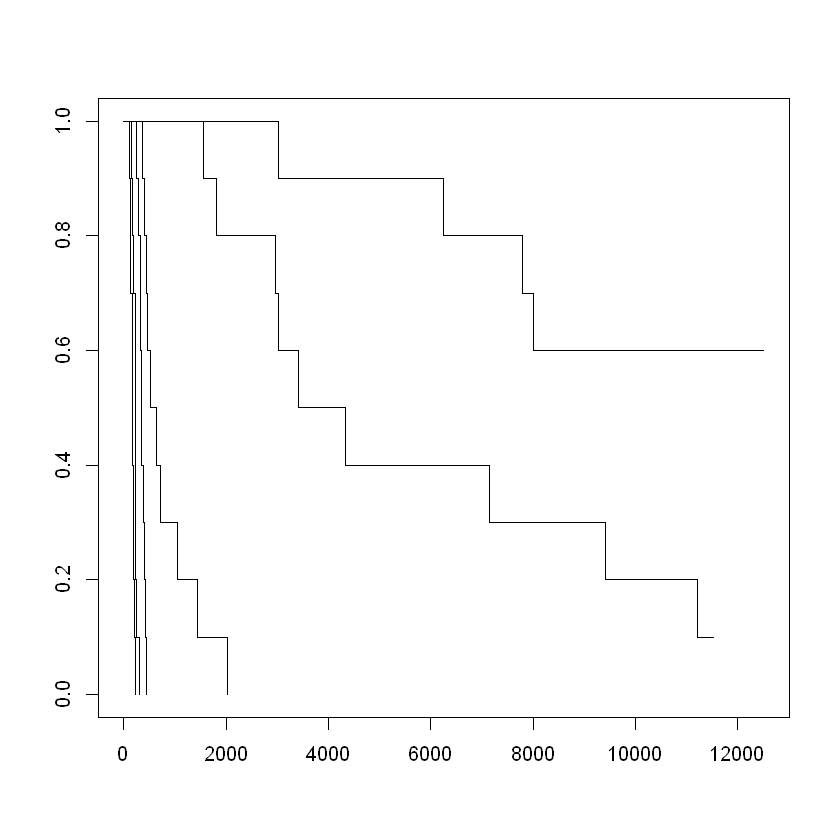

In [8]:
plot(survfit(Surv(y, delta) ~ x, spring), conf.int = FALSE)

In [9]:
# Distribution 
norm1 <- survreg(Surv(y,delta)~log(x),dist="lognormal",data=spring) #y~log-normal, log(x)
norm2 <- survreg(Surv(y,delta)~x,dist="lognormal",data=spring) #y~log-normal, x
logistic1 <- survreg(Surv(y,delta)~log(x),dist="loglogistic",data=spring) #y~log-logistic, log(x)
logistic2 <- survreg(Surv(y,delta)~x,dist="loglogistic",data=spring) #y~log-logistic, x
gomp1 <- survreg(Surv(y,delta)~log(x),dist="weibull",data=spring) #y~weibull, log(x)
gomp2 <- survreg(Surv(y,delta)~x,dist="weibull",data=spring) #y~weibull, x

In [10]:
# AIC : norm1, norm2, logistic1, logistic2, gomp1, gomp2 
cbind(AIC(norm1), AIC(norm2), AIC(logistic1), AIC(logistic2), AIC(gomp1), AIC(gomp2))

795.5539,802.7075,797.0306,804.8699,803.0983,809.7935


In [11]:
# norm1 : Surv(y,delta)~log(x),dist="lognormal" 
norm1

Call:
survreg(formula = Surv(y, delta) ~ log(x), data = spring, dist = "lognormal")

Coefficients:
(Intercept)      log(x) 
  105.69738   -14.74356 

Scale= 0.6268596 

Loglik(model)= -394.8   Loglik(intercept only)= -451.5
	Chisq= 113.37 on 1 degrees of freedom, p= <2e-16 
n= 60 

### (d) ALT predictive distribution 
* $P(T>t | x_1, ..., x_p) = 1 - G(\frac{\ln{t} - \hat \mu}{\hat \sigma})$

In [12]:
beta0 <- norm1$coefficients[1]
beta1 <- norm1$coefficients[2]
sigma <- summary(norm1)$scale

In [13]:
# x = 700
x <- 700
mu <- beta0+beta1*log(x)
1 - pnorm((log(10000)-mu)/sigma)

(Intercept) 
  0.4371075

* x=700일 때, 용수철의 수명이 10000 이상일 확률은 0.437이다.

In [14]:
# x = 650
x <- 650
mu <- beta0+beta1*log(x)
1 - pnorm((log(10000)-mu)/sigma)

(Intercept) 
  0.9434818

* x=650일 때, 용수철의 수명이 10000 이상일 확률은 0.943이다.

### PART 2. Stanford Heart Transplant Data 
심장병환자의 **공변량(covariates)** $(x_{i1}, x_{i2})$을 이용하여 심장이식 수술 후 환자의 **생존시간($t_i$)의 분포**를 예측하는 적절한 **회귀모형**을 찾는다. 
* $y_{i} = min(t_{i}, c_{i})$ 
  - $t_{i}$ : survival times (days) of patients 
  - $c_{i}$ : censoring times (days) of patients 
* $\delta_{i} = I(t_{i} \leq c_{i}) =$  1, dead (uncensored) / 0, alive (censored) 
* $x_{i1}$ : age of the patients (years)
* $x_{i2}$ : mismatch score 
* $i = 1, ..., n ; n= 184$

In [7]:
Heart <- read_excel("Spring-Failure-Stanford-heart-Transplant.xls",
                     sheet = "Stanford-Heart-Transplant-Data", na="*")[,2:6]
Heart <- Heart[complete.cases(Heart),] # remove missing data 
colnames(Heart) <- c('t','cens','x1','x2','lnT') # cens: 1 if dead else 0

### (a) (lny, x), (lny, lnx) 산점도 

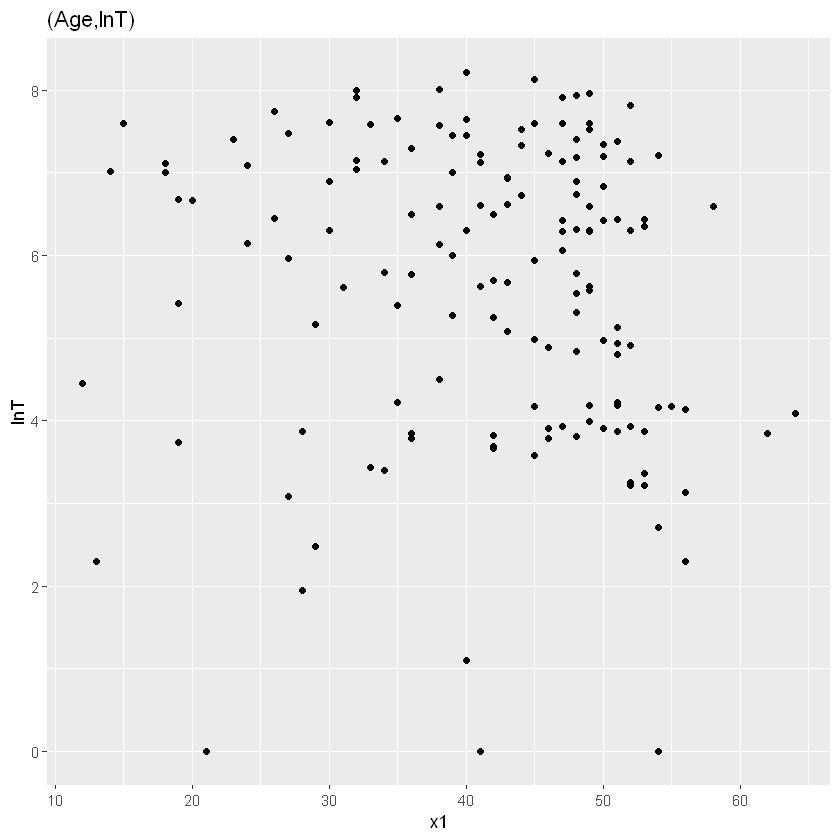

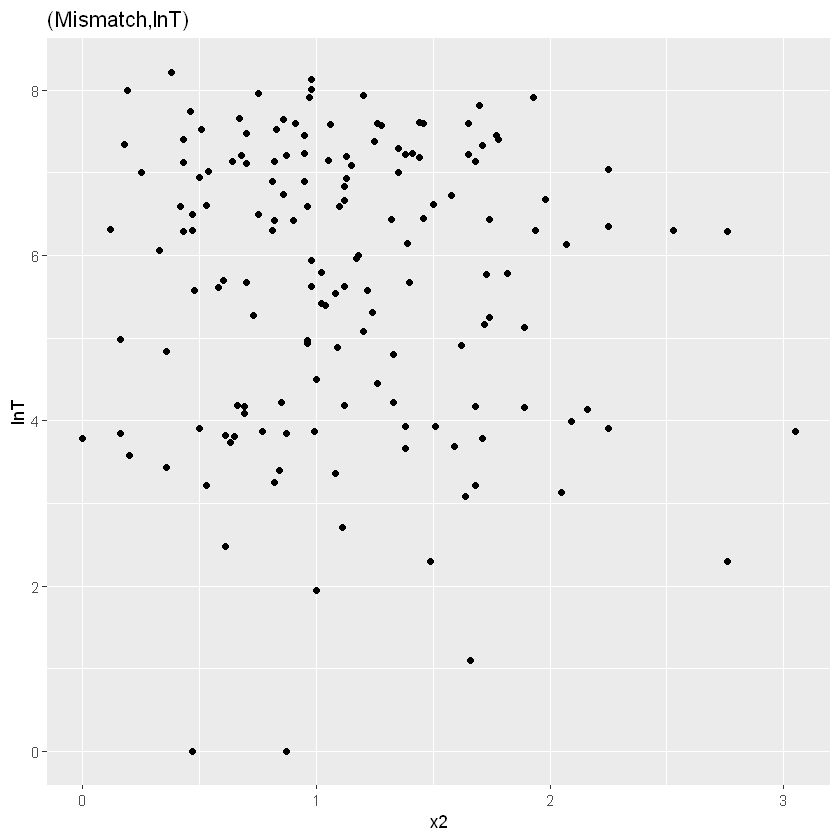

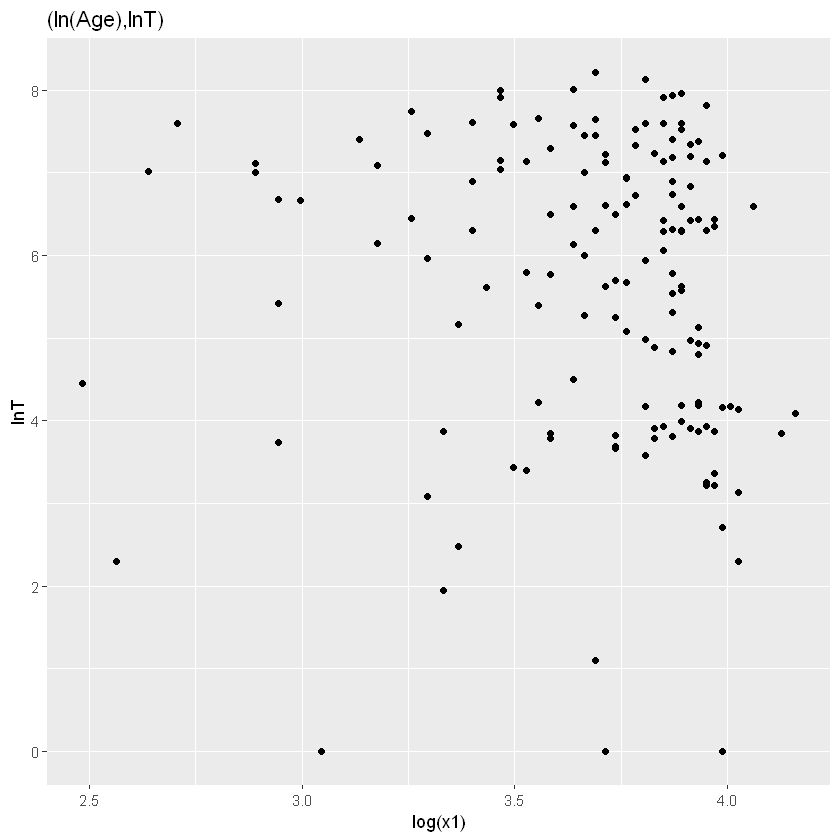

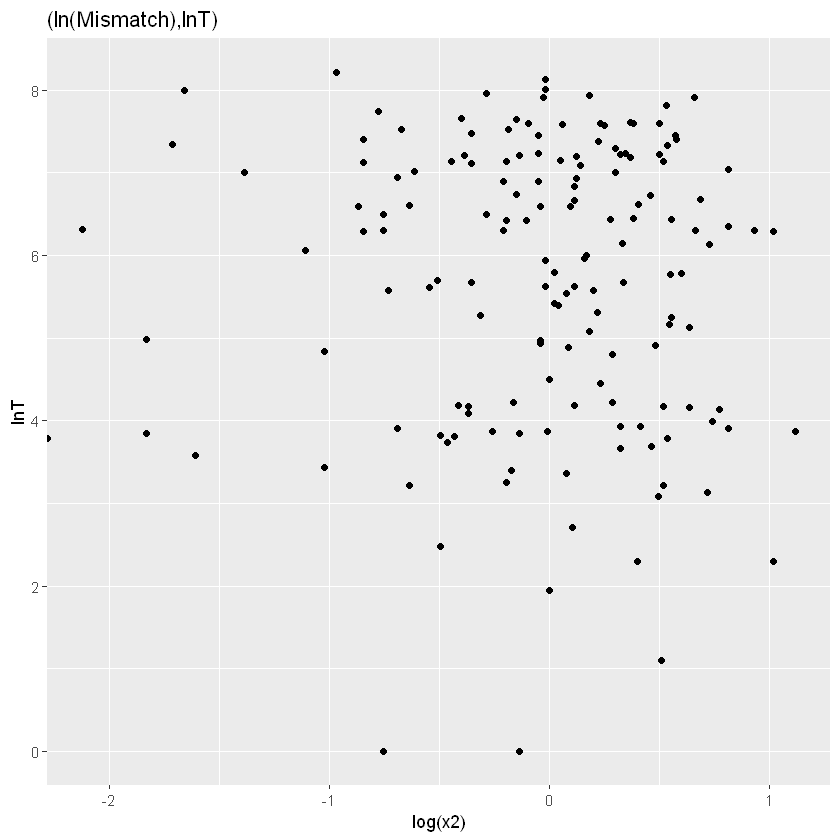

In [16]:
ggplot(Heart,aes(x1,lnT))+geom_point()+ggtitle("(Age,lnT)")
ggplot(Heart,aes(x2,lnT))+geom_point()+ggtitle("(Mismatch,lnT)")
ggplot(Heart,aes(log(x1),lnT))+geom_point()+ggtitle("(ln(Age),lnT)")
ggplot(Heart,aes(log(x2),lnT))+geom_point()+ggtitle("(ln(Mismatch),lnT)")

* Age와 Mismatch Score 모두 환자의 잔여수명과 관계가 없다.

### (b) ALT (Accelerated Life Test) 모형 찾기 
* $T_i = exp(\mu_i) \cdot T_{i0}^\sigma$
* $\ln{T_i} = \mu_i + \sigma \ln{T_{i0}}$
* $\mu_i = \beta_0 + \Sigma_{j=1}^{p}\beta_j x_{ij}$
* $U_i = \ln{T_{i0}} \sim G(u)$ ; N(0,1), L(0,1), Gompertz(0,1), etc. 
* $i=1, ..., n$ 

In [21]:
#weibull
alt_w1 <- survreg(Surv(t, cens) ~ x1 + x2 , data = Heart, dist = 'weibull')
alt_w2 <- survreg(Surv(t, cens) ~ x1 + x2 + x1*x2 , data = Heart, dist = 'weibull')
alt_w3 <- survreg(Surv(t, cens) ~ log(x1) + x2, data = Heart, dist = 'weibull')
alt_w4 <- survreg(Surv(t, cens) ~ log(x1) + x2 + log(x1)*x2 , data = Heart, dist = 'weibull')
alt_w5 <- survreg(Surv(t, cens) ~ I(1/x1) + x2 , data = Heart, dist = 'weibull')
alt_w6 <- survreg(Surv(t, cens) ~ I(1/x1) + x2 + I(1/x1)*x2, data = Heart, dist = 'weibull')
alt_w7 <- survreg(Surv(t, cens) ~ x1 + x2 + I(x1^2) + I(x2^2) , data = Heart, dist = 'weibull')

In [18]:
#loglogistic
alt_ll1 <- survreg(Surv(t, cens) ~ x1 + x2 , data = Heart, dist = 'loglogistic')
alt_ll2 <- survreg(Surv(t, cens) ~ x1 + x2 + x1*x2 , data = Heart, dist = 'loglogistic')
alt_ll3 <- survreg(Surv(t, cens) ~ log(x1) + x2 , data = Heart, dist = 'loglogistic')
alt_ll4 <- survreg(Surv(t, cens) ~ log(x1) + x2 + log(x1)*x2 , data = Heart, dist = 'loglogistic')
alt_ll5 <- survreg(Surv(t, cens) ~ I(1/x1) + x2 , data = Heart, dist = 'loglogistic')
alt_ll6 <- survreg(Surv(t, cens) ~ I(1/x1) + x2 + I(1/x1)*x2 , data = Heart, dist = 'loglogistic')
alt_ll7 <- survreg(Surv(t, cens) ~ x1 + x2 + I(x1^2) + I(x2^2) , data = Heart, dist = 'loglogistic')

In [19]:
#lognormal
alt_n1 <- survreg(Surv(t, cens) ~ x1 + x2 , data = Heart, dist = 'lognormal')
alt_n2 <- survreg(Surv(t, cens) ~ x1 + x2 + x1*x2 , data = Heart, dist = 'lognormal')
alt_n3 <- survreg(Surv(t, cens) ~ log(x1) + x2 , data = Heart, dist = 'lognormal')
alt_n4 <- survreg(Surv(t, cens) ~ log(x1) + x2 + log(x1)*x2 , data = Heart, dist = 'lognormal')
alt_n5 <- survreg(Surv(t, cens) ~ I(1/x1) + x2 , data = Heart, dist = 'lognormal')
alt_n6 <- survreg(Surv(t, cens) ~ I(1/x1) + x2 + I(1/x1)*x2 , data = Heart, dist = 'lognormal')
alt_n7 <- survreg(Surv(t, cens) ~ x1 + x2 + I(x1^2) + I(x2^2) , data = Heart, dist = 'lognormal')

In [20]:
cbind(AIC(alt_w1),AIC(alt_w2),AIC(alt_w3),AIC(alt_w4),AIC(alt_w5),AIC(alt_w6), AIC(alt_w7))
cbind(AIC(alt_ll1),AIC(alt_ll2),AIC(alt_ll3),AIC(alt_ll4),AIC(alt_ll5),AIC(alt_ll6), AIC(alt_ll7))
cbind(AIC(alt_n1),AIC(alt_n2),AIC(alt_n3),AIC(alt_n4),AIC(alt_n5),AIC(alt_n6),AIC(alt_ll7))

1577.762,1577.1,1580.831,1580.937,1583.582,1584.798,1571.092


1577.566,1576.206,1580.207,1579.899,1582.459,1583.643,1571.857


1577.033,1576.183,1578.892,1579.101,1580.243,1581.688,1571.857


In [21]:
# alt_w7 : Surv(t, cens) ~ x1 + x2 + I(x1^2) + I(x2^2), dist = 'weibull') 
summary(alt_w7)


Call:
survreg(formula = Surv(t, cens) ~ x1 + x2 + I(x1^2) + I(x2^2), 
    data = Heart, dist = "weibull")
               Value Std. Error     z       p
(Intercept)  3.72316    1.80775  2.06  0.0394
x1           0.24740    0.09338  2.65  0.0081
x2           1.01611    0.99258  1.02  0.3060
I(x1^2)     -0.00394    0.00122 -3.23  0.0012
I(x2^2)     -0.49939    0.35024 -1.43  0.1539
Log(scale)   0.54393    0.08373  6.50 8.2e-11

Scale= 1.72 

Weibull distribution
Loglik(model)= -779.5   Loglik(intercept only)= -789.7
	Chisq= 20.24 on 4 degrees of freedom, p= 0.00045 
Number of Newton-Raphson Iterations: 5 
n= 157 


### (c) ALT predictive distribution 
* $P(t>365 | x_1, x_2) = 1 - G(\frac{\ln{365} - (\hat \beta_0 + \Sigma_{j=1}^{p} \hat \beta_j x_{j})}{\hat \sigma})$

In [22]:
beta0 <- alt_w7$coefficients[1]
beta1 <- alt_w7$coefficients[2]
beta2 <- alt_w7$coefficients[3]
beta3 <- alt_w7$coefficients[4]
beta4 <- alt_w7$coefficients[5]
sigma <- alt_w7$scale

In [23]:
# (x1,x2) = (50,1)
x1<-50; x2<-1 
mu <- beta0 + beta1*x1 + beta2*x2 + beta3*(x1^2) + beta4*(x2^2)
u <- ((log(365)-mu)/sigma)
prob_alt <- exp(-exp(u)) ; prob_alt

(Intercept) 
   0.545982

* Age가 50이고 Mismatch Score가 1점인 환자의 1년 이상 생존확률은 0.546이다.

### (d) Cox-PHM
* $h(t|x_1, ..., x_p) = h(t) exp(x'\beta)$
* $x = (x_1, ..., x_p)', \beta = (\beta_1, ..., \beta_p)'$
* h(t) : **unknown** (baseline hazard rate function) 

In [8]:
# centering : x* = x - mean(x) 
Heart_c <- mutate(Heart, x1 = (x1 - mean(x1)), x2 = (x2 - mean(x2)) )

#### (i) AIC를 이용하여 모형 선택 

In [9]:
cox1 <- coxph(Surv(t, cens) ~ x1 + x2, data = Heart_c)
cox2 <- coxph(Surv(t, cens) ~ x1 + x2 + x1*x2, data = Heart_c)
cox3 <- coxph(Surv(t, cens) ~ x1 + x2 + I(x1^2) + I(x2^2), data = Heart_c)
cbind(AIC(cox1), AIC(cox2), AIC(cox3))

897.721,897.1773,891.2169


In [10]:
# Surv(t, cens) ~ x1 + x2 + I(x1^2) + I(x2^2)
summary(cox3)

Call:
coxph(formula = Surv(t, cens) ~ x1 + x2 + I(x1^2) + I(x2^2), 
    data = Heart_c)

  n= 157, number of events= 102 

             coef exp(coef)  se(coef)     z Pr(>|z|)    
x1      0.0446575 1.0456696 0.0109847 4.065 4.79e-05 ***
x2      0.0527845 1.0542024 0.1929953 0.274  0.78447    
I(x1^2) 0.0022438 1.0022463 0.0007046 3.184  0.00145 ** 
I(x2^2) 0.2937531 1.3414526 0.2036336 1.443  0.14915    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

        exp(coef) exp(-coef) lower .95 upper .95
x1          1.046     0.9563    1.0234     1.068
x2          1.054     0.9486    0.7222     1.539
I(x1^2)     1.002     0.9978    1.0009     1.004
I(x2^2)     1.341     0.7455    0.9000     1.999

Concordance= 0.605  (se = 0.033 )
Likelihood ratio test= 18.97  on 4 df,   p=8e-04
Wald test            = 21.95  on 4 df,   p=2e-04
Score (logrank) test = 22.35  on 4 df,   p=2e-04


#### (ii) H(t) : baseline cummulative hazard ftn / S(t) : survival ftn

In [3]:
library(survminer)

Warning message:
"package 'survminer' was built under R version 3.6.3"
Loading required package: ggplot2

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Loading required package: ggpubr

Warning message:
"package 'ggpubr' was built under R version 3.6.3"


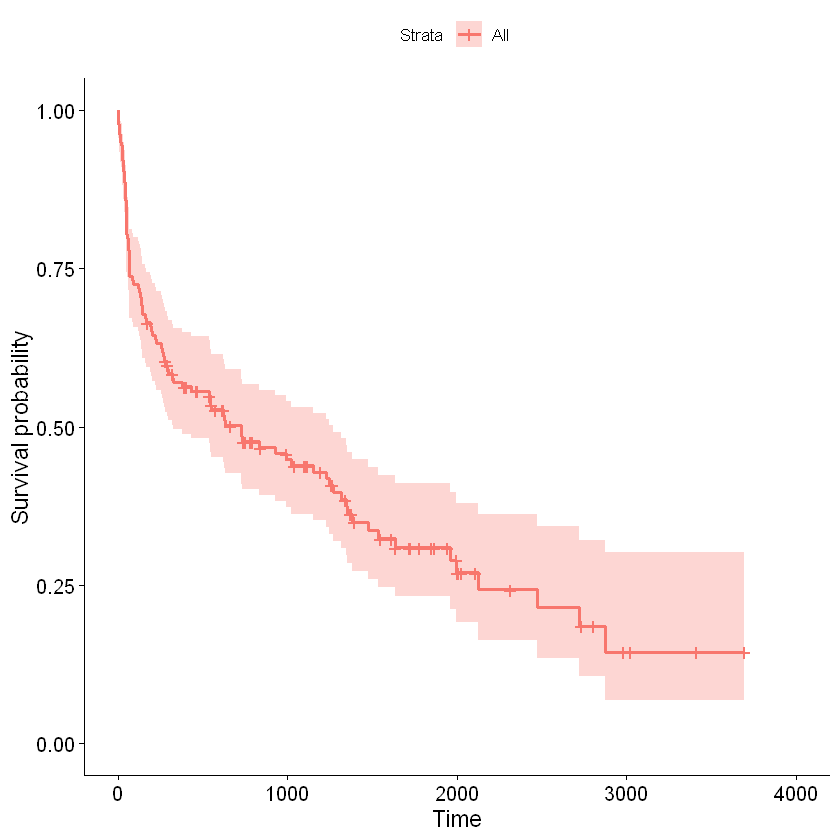

In [11]:
ggsurvplot(survfit(cox3), data = Heart_c)

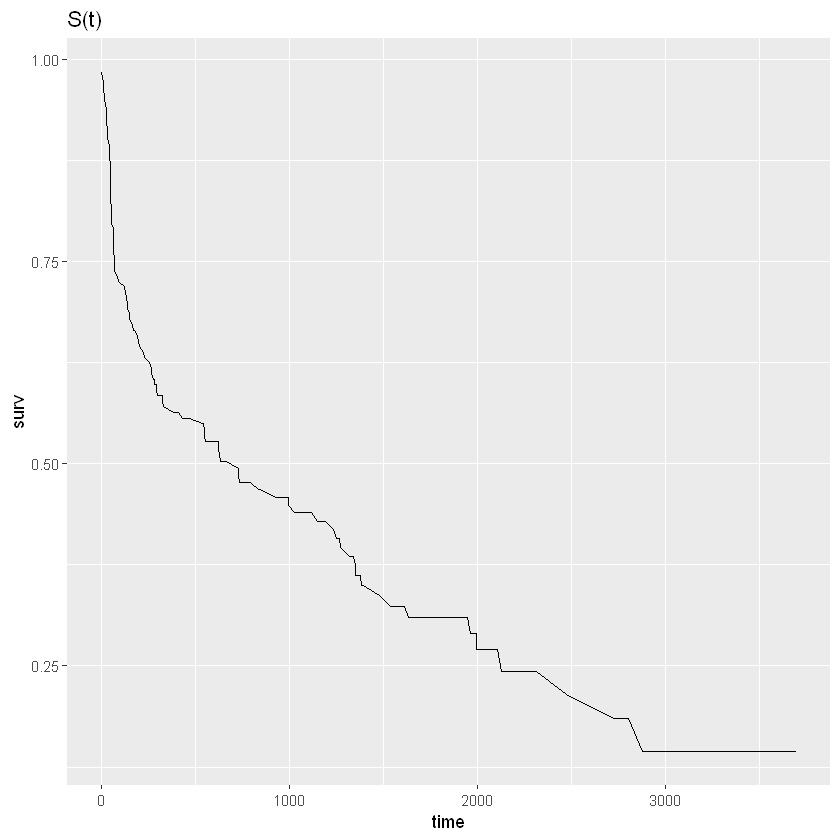

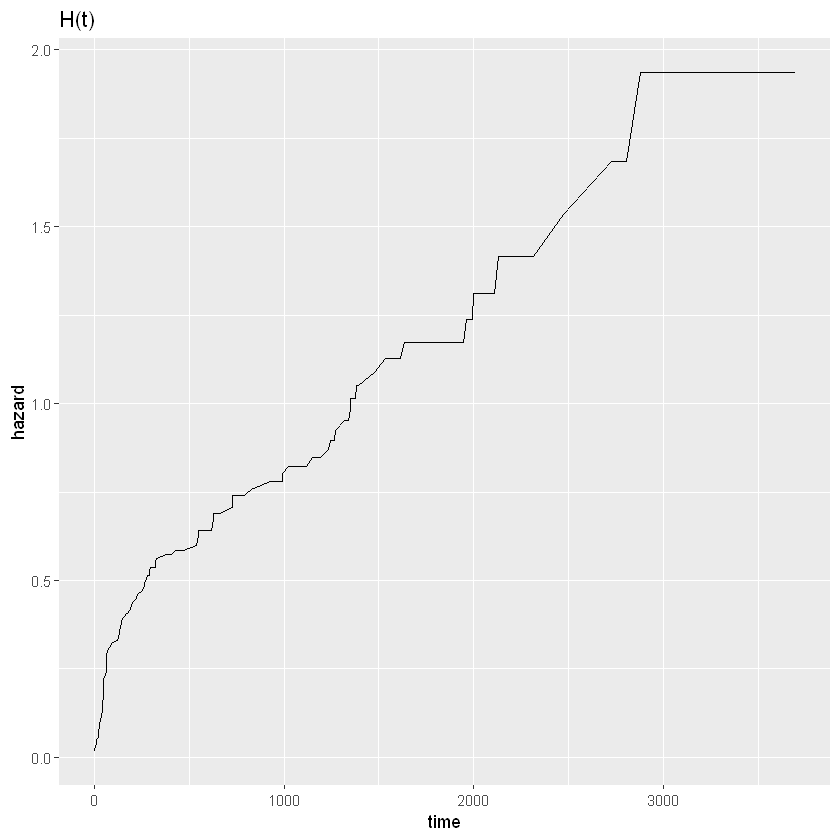

In [12]:
S <-data.frame(time = survfit(cox3)$time, surv = survfit(cox3)$surv,
               hazard = -log(survfit(cox3)$surv))
ggplot(S,aes(time,surv))+geom_line()+ggtitle('S(t)')
ggplot(S,aes(time,hazard))+geom_line()+ggtitle('H(t)')

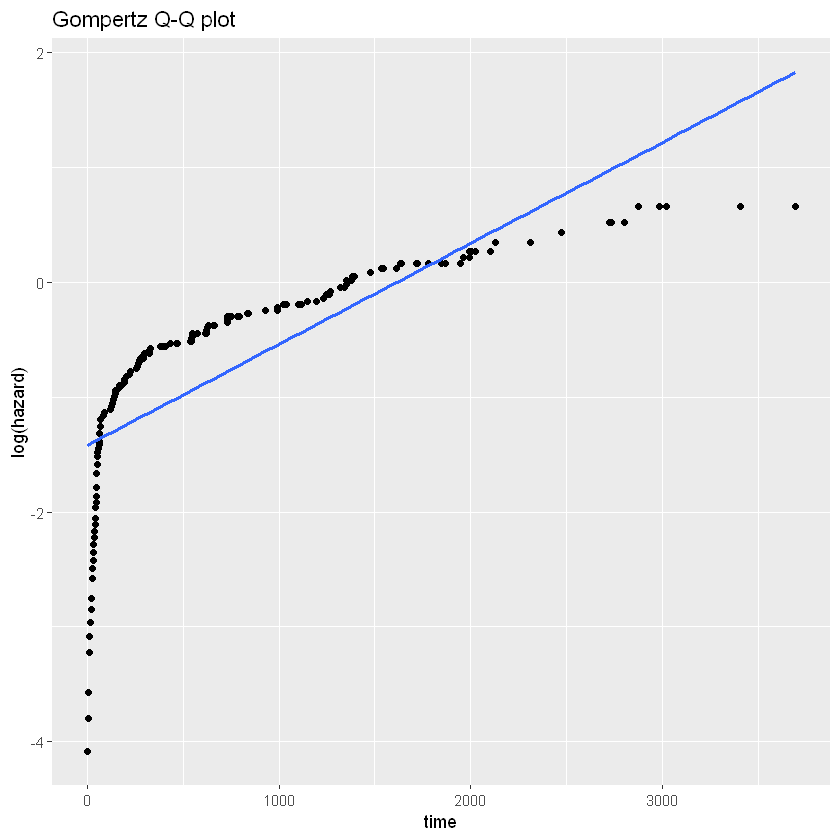

In [13]:
# H(t) Gompertz Q-Q Plot
ggplot(S,aes(time,log(hazard)))+geom_point()+geom_smooth(method="lm",se=F)+ggtitle('Gompertz Q-Q plot')

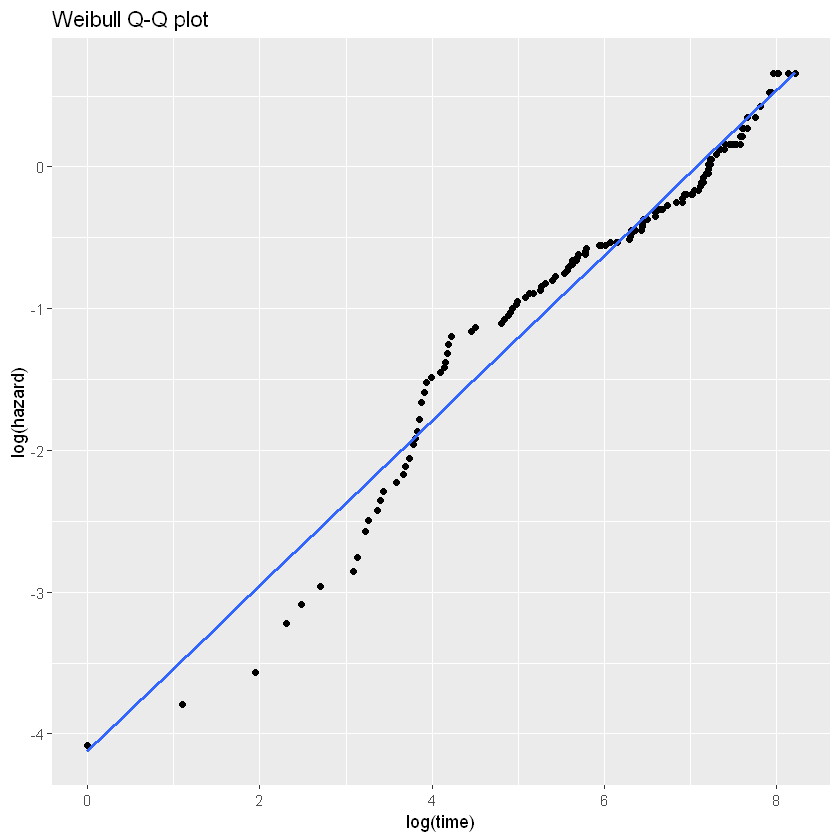

In [14]:
# H(t) Weibull Q-Q Plot
ggplot(S,aes(log(time), log(hazard)))+geom_point()+geom_smooth(method="lm",se=F)+ggtitle('Weibull Q-Q plot')

In [15]:
# Weibull 
lm_wei <- lm(log(hazard) ~ log(time), data = S)
summary(lm_wei)


Call:
lm(formula = log(hazard) ~ log(time), data = S)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.57817 -0.10259 -0.03545  0.14632  0.47071 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.123549   0.058452  -70.55   <2e-16 ***
log(time)    0.582986   0.009557   61.00   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1864 on 142 degrees of freedom
Multiple R-squared:  0.9632,	Adjusted R-squared:  0.963 
F-statistic:  3721 on 1 and 142 DF,  p-value: < 2.2e-16


#### (iii) Cox-PHM predictive distribution 
* $p(t>365 | x_1, x_2) = S(365 | x_1, x_2) = S(365)^{\hat \mu (x_1, x_2)}$
* $\hat \mu (x_1, x_2) = exp(\Sigma_{j=1}^{p}\hat \beta_j x_{j}^*$
* $x_{j}^* = x_j - \bar x_j ; j = 1, ..., p$

In [16]:
alpha <- summary(lm_wei)$coefficients[1]
beta <- summary(lm_wei)$coefficients[2]

In [17]:
# (x1, x2) = (50, 1) : Baseline hazard rate
Ht_base <- exp(alpha+beta*log(365)) ; Ht_base 

[1] 0.5045982

In [18]:
# Baseline survival
St_base <- exp(-Ht_base) ; St_base

[1] 0.6037481

In [19]:
# Survival Rate (50,1)
cox.mu <- exp(predict(cox3, data.frame(x1 = 50- mean(Heart$x1),x2 = 1-mean(Heart$x2)), type = 'lp'))
prob.cox <- St_base^cox.mu ; prob.cox

1 
0.5503613

* ALT : 0.546 / Cox-PHM : 0.555 
* 두 방법 모두 비슷한 결과값이 나왔다. 

### (e) ALT 모형의 적합성 검토

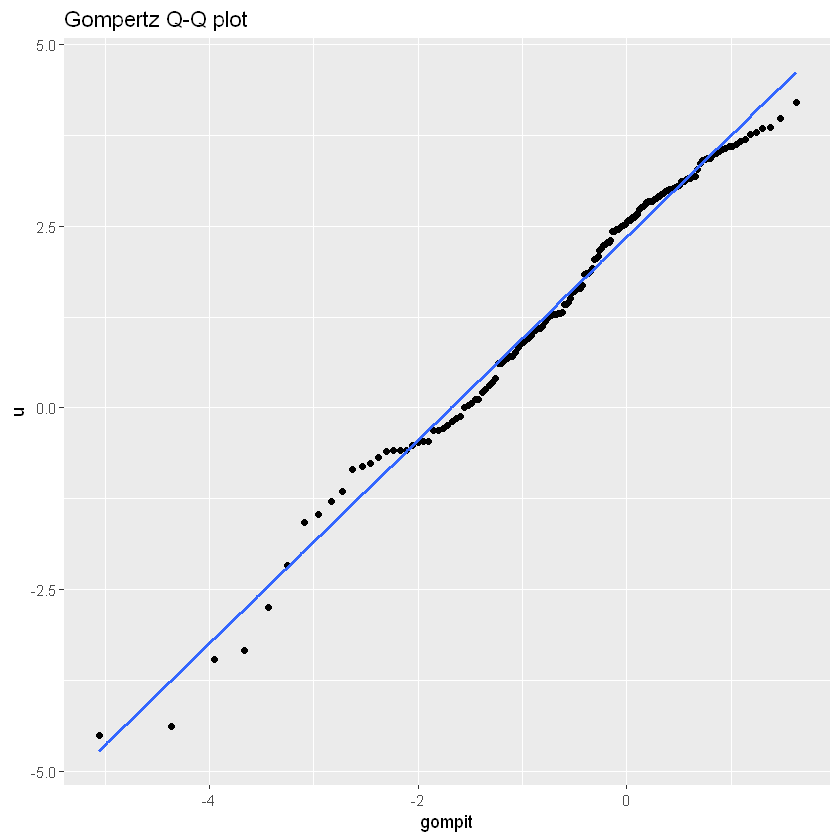

In [23]:
mu <- beta0 + beta1*Heart$x1 + beta2*Heart$x2 + beta3*Heart$x1^2 + beta4*Heart$x2^2
m.alt.data <- data.frame(u = log(Heart$t)-mu/sigma) %>% mutate(r = rank(u), p = r/(length(Heart$t)+1), gompit = log(-log(1-p)))
ggplot(m.alt.data, aes(gompit, u)) + geom_point() + geom_smooth(method='lm', se = F) + ggtitle('Gompertz Q-Q plot')

* 직선의 형태를 보이므로 Gompertz분포를 잘 따른다고 볼 수 있다.

#### ALT vs Cox-PHM
* ALT모형과 PHM모형 모두 **Censored Data**가 있는 경우에 대한 **Regression**이다.
* **ALT** : 분포를 가정해서 추정 / **Cox-PHM** : 분포를 가정하지 않고 추정     
  **(ALT : parameteric / Cox-PHM : semi-parametric)**


* **ALT** 모형은 수준에 따라서 수명을 예측하기 때문에 관측기간을 줄여 시간을 절약할 수 있다. 
* 하지만 ALT 모형을 적합시키기 위해서는 적어도 3개 이상의 level이 필요하다. 
* 또한, 초기값에 따라 Global Minimum이 아닌 Local Minimum으로 수렴할 가능성이 존재한다. 
* **Cox-PHM** 모형은 수명의 분포를 모르는 경우에도 추정이 가능하며, ALT보다 일반적이다. 
* 하지만 Proportional hazards 가정을 만족하지를 않으면 잘못 추정될 수 있다.